## Import libraries and read input file/files

In [1]:
!pip install paddlehub==2.0.0 -q
!pip install paddlepaddle==2.1.1 -q
!pip install PaddleNLP==2.0.2 -q
!pip install Unidecode==1.3.4 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.6/191.6 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.5/189.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.7/128.7 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.0/101.0 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 13.1 MB/s eta 0:00

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os
folder = '/content/gdrive/My Drive/ocr/'
os.chdir(folder)
files = os.listdir(folder)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import paddlehub as hub
import cv2
import numpy as np
import os
import time
import copy
import pandas as pd
from google.colab.patches import cv2_imshow
import sys
import string
from unidecode import unidecode
import re

/usr/local/lib/python3.7/dist-packages/scipy/fft/__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecati

In [ ]:
# image file name
files = ['alpha_mart3.jpg']

## Utils

In [ ]:
def draw_bounding_boxes(image,boxes):
    '''
    This function will draw bounding box on images
    Args:
        boxes : list of bounding boxes
    Return:
        image : image with bounding boxes
    '''
    for box in boxes:
        image = cv2.rectangle(copy.deepcopy(image),tuple(box[:2]), tuple(box[2:]), (255,0,0), 3)
    return image


In [ ]:
def NMS(boxes, overlapThresh = 0):
    '''
    This function utilizes the idea of Non-maximum Suppression (NMS). Bounding boxes will be combined if their area of overlap exceeds overlapThresh
    Args:
        boxes : original list of bounding boxes
        overlapThresh: threshold for overlapping area/area of each bounding boxes
    Return:
        combined_list : combined list of bounding boxes, each element of the list contains one or more indexes with refer to the list of bounding boxes to be combined
    '''
    #return an empty list, if no boxes given
    if len(boxes) == 0:
        return []
    x1 = boxes[:, 0]  # x coordinate of the top-left corner
    y1 = boxes[:, 1]  # y coordinate of the top-left corner
    x2 = boxes[:, 2]  # x coordinate of the bottom-right corner
    y2 = boxes[:, 3]  # y coordinate of the bottom-right corner
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    areas = (x2 - x1 + 1) * (y2 - y1 + 1) # We have a least a box of one pixel, therefore the +1
    indices = np.arange(len(x1))
    combined_ind = []

    for i,box in enumerate(boxes):
        temp_indices = indices
        xx1 = np.maximum(box[0], boxes[temp_indices,0])
        yy1 = np.maximum(box[1], boxes[temp_indices,1])
        xx2 = np.minimum(box[2], boxes[temp_indices,2])
        yy2 = np.minimum(box[3], boxes[temp_indices,3])
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        #print(areas[temp_indices])
        overlap = (w * h) / areas[temp_indices]
        # if overlap higher than threshold: store into states -> ind_lst store all other states overlapping with the current one
        states = (overlap > overlapThresh)
        #print(states)
        ind_lst = np.where(states)[0] # the list oredy included the current target box (100% overlap)
        #print(ind_lst)
        combined_ind.append(ind_lst.tolist())

    return combined_ind


In [ ]:
def pool(mat, ii=0):
    '''
    This function combine lists of lists to lists of lists where each element of bigger lists have no overlapping elements with other lists

    '''
    if ii >= len(mat) - 1:
        return mat
    for i in range(ii+1, len(mat)):
        if set(mat[i]) & set(mat[ii]):
            mat[ii] = sorted(list(set(mat.pop(i)) | set(mat[ii])))
            return pool(mat, ii)
    return pool(mat, ii+1)

In [ ]:
def accented_characters_removal(text):
    """
    The function will remove accented characters from the
    text contained within the Dataset.

    arguments:
        input_text: "text" of type "String".

    return:
        value: "text" with removed accented characters.

    Example:
    Input : Málaga, àéêöhello
    Output : Malaga, aeeohello

    """


    # Remove accented characters from text using unidecode.
    # Unidecode() - It takes unicode data & tries to represent it to ASCII characters.
    return unidecode(text)

In [ ]:
# The code for removing special characters
def removing_special_characters(text):
    """Removing all the special characters except the one that is passed within
       the regex to match, as they have imp meaning in the text provided.


    arguments:
         input_text: "text" of type "String".

    return:
        value: Text with removed special characters that don't require.

    Example:
    Input : Hello, K-a-j-a-l. Thi*s is $100.05 : the payment that you will recieve! (Is this okay?)
    Output :  Hello Kajal This is 100 05 : the payment that you will recieve Is this okay

   """

    # The formatted text after removing not necessary punctuations.
    formatted_Text = re.sub(r'[“”;’，‘?!…#]', ' ',text)

    return formatted_Text

In [ ]:
def remove_other_char(text):

  #sen = re.sub('\d+', '',text)
  # Remove text with less than or equal to 2 characters
  if len(text)<=2:
    return ''
  else:
    return text




In [ ]:
def lower_casing_text(text):

    """
    The function will convert text into lower case.

    arguments:
         input_text: "text" of type "String".

    return:
         value: text in lowercase

    Example:
    Input : The World is Full of Surprises!
    Output : the world is full of surprises!

    """

    # Convert text to lower case
    # lower() - It converts all upperase letter of given string to lowercase.
    return_text = text.lower()
    return return_text

In [ ]:
def remove_whitespace(text):
    """ This function will remove
        extra whitespaces from the text
    arguments:
        input_text: "text" of type "String".

    return:
        value: "text" after extra whitespaces removed .

    Example:
    Input : How   are   you   doing   ?
    Output : How are you doing ?

    """

    pattern = re.compile(r'\s+')
    without_whitespace = re.sub(pattern, ' ', text)

    return without_whitespace


## Image processing

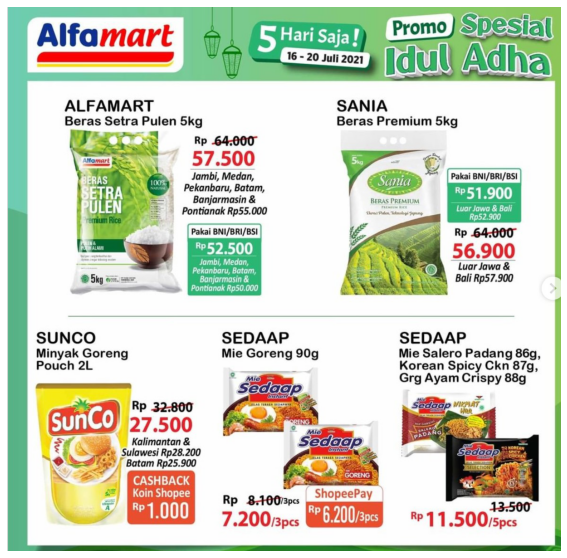

In [ ]:
# print the image
img1 = mpimg.imread(files[0])
plt.figure(figsize=(10,10))
plt.imshow(img1)
plt.axis('off')
plt.show()

### OCR based on pretrained paddle model

In [ ]:
# load pre-trained OCR model (by Paddle) based on Chinese and English
# For reference: https://aistudio.baidu.com/aistudio/projectdetail/507159
ocr = hub.Module(name="chinese_ocr_db_crnn_mobile")

/usr/local/lib/python3.7/dist-packages/pip/_vendor/packaging/version.py:130: DeprecationWarning: Creating a LegacyVersion has been deprecated and will be removed in the next major release
  DeprecationWarning,
/usr/local/lib/python3.7/dist-packages/pip/_vendor/packaging/version.py:130: DeprecationWarning: Creating a LegacyVersion has been deprecated and will be removed in the next major release
  DeprecationWarning,


Download https://bj.bcebos.com/paddlehub/paddlehub_dev/chinese_ocr_db_crnn_mobile-1.1.2.tar.gz
[##################################################] 100.00%
Decompress /root/.paddlehub/tmp/tmpmroqr15j/chinese_ocr_db_crnn_mobile-1.1.2.tar.gz
[##################################################] 100.00%

[2022-06-21 02:33:41,307] [    INFO] - Successfully installed dependent packages.
[2022-06-21 02:33:41,545] [    INFO] - Successfully installed chinese_ocr_db_crnn_mobile-1.1.2
[2022-06-21 02:33:41,558] [ WARNING] - The _initialize method in HubModule will soon be deprecated, you can use the __init__() to handle the initialization of the object


In [ ]:
np_images =[cv2.imread(image_path) for image_path in files]

results = ocr.recognize_text(
                    images=np_images,         # image data, ndarray.shape: [H, W, C]，BGR format；
                    use_gpu=False,            # whether to use GPU；if using GPU，pls set CUDA_VISIBLE_DEVICES first
                    output_dir='ocr_result',  # save path of results, default folder: ocr_result；
                    visualization=True,       # whether to save result as image；
                    box_thresh=0.5,           # text box recognition confidence threshold；
                    text_thresh=0.5)          # Chinese text box recognition confidence threshold；

for result in results:
    data = result['data']
    save_path = result['save_path']
    df = pd.DataFrame(data)
    # for infomation in data:
    #     print('text: ', infomation['text'], '\nconfidence: ', infomation['confidence'], '\ntext_box_position: ', infomation['text_box_position'])


Download https://bj.bcebos.com/paddlehub/paddlehub_dev/chinese_text_detection_db_mobile-1.0.4.tar.gz
[##################################################] 100.00%
Decompress /root/.paddlehub/tmp/tmprrvn0y_e/chinese_text_detection_db_mobile-1.0.4.tar.gz
[##################################################] 100.00%

[2022-06-21 02:34:04,695] [    INFO] - Successfully installed dependent packages.
[2022-06-21 02:34:04,836] [    INFO] - Successfully installed chinese_text_detection_db_mobile-1.0.4
[2022-06-21 02:34:04,843] [ WARNING] - The _initialize method in HubModule will soon be deprecated, you can use the __init__() to handle the initialization of the object
/root/.paddlehub/modules/chinese_text_detection_db_mobile/processor.py:207: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xmin = np.clip(np.floor(box[:, 0].min()).astype(np.int), 0, w - 1)
/root/.pad

In [ ]:
df.head()

text  confidence                                 text_box_position
0     Spesial    0.993894     [[955, 7], [1152, 14], [1151, 70], [954, 64]]
1       Promo    0.988609      [[806, 20], [933, 16], [934, 60], [808, 64]]
2    Alfamart    0.958254        [[64, 30], [348, 35], [347, 87], [63, 82]]
3  Hari Saja!    0.922916      [[574, 33], [744, 44], [742, 84], [571, 74]]
4   idul Adha    0.886033  [[794, 66], [1146, 71], [1145, 150], [793, 145]]

In [ ]:
#remove objects with confidence of less than 80%
df = df[df.confidence>0.8]
df = df.reset_index(drop=True)

In [ ]:
# split text box position into four corner positions (1: top-left 2:top-right 3:bottom-left 4:bottom-right)
split_df = pd.DataFrame(df['text_box_position'].tolist(), columns=['pos1', 'pos2', 'pos3','pos4'])
df = pd.concat([df.iloc[:,:-1],split_df],axis = 1)
# attach a running number to each of the text recognized
df['lab'] = np.arange(len(df))
for i in range(4):
  pos_name = 'pos'+ str(i+1)
  pos_name_new1 = pos_name+'_x'
  pos_name_new2 = pos_name+'_y'
  split_df = pd.DataFrame(df[pos_name].tolist(), columns=[pos_name_new1, pos_name_new2])
  df = pd.concat([df,split_df],axis = 1)
df.head()

text  confidence       pos1        pos2         pos3        pos4  \
0     Spesial    0.993894   [955, 7]  [1152, 14]   [1151, 70]   [954, 64]   
1       Promo    0.988609  [806, 20]   [933, 16]    [934, 60]   [808, 64]   
2    Alfamart    0.958254   [64, 30]   [348, 35]    [347, 87]    [63, 82]   
3  Hari Saja!    0.922916  [574, 33]   [744, 44]    [742, 84]   [571, 74]   
4   idul Adha    0.886033  [794, 66]  [1146, 71]  [1145, 150]  [793, 145]   

   lab  pos1_x  pos1_y  pos2_x  pos2_y  pos3_x  pos3_y  pos4_x  pos4_y  
0    0     955       7    1152      14    1151      70     954      64  
1    1     806      20     933      16     934      60     808      64  
2    2      64      30     348      35     347      87      63      82  
3    3     574      33     744      44     742      84     571      74  
4    4     794      66    1146      71    1145     150     793     145

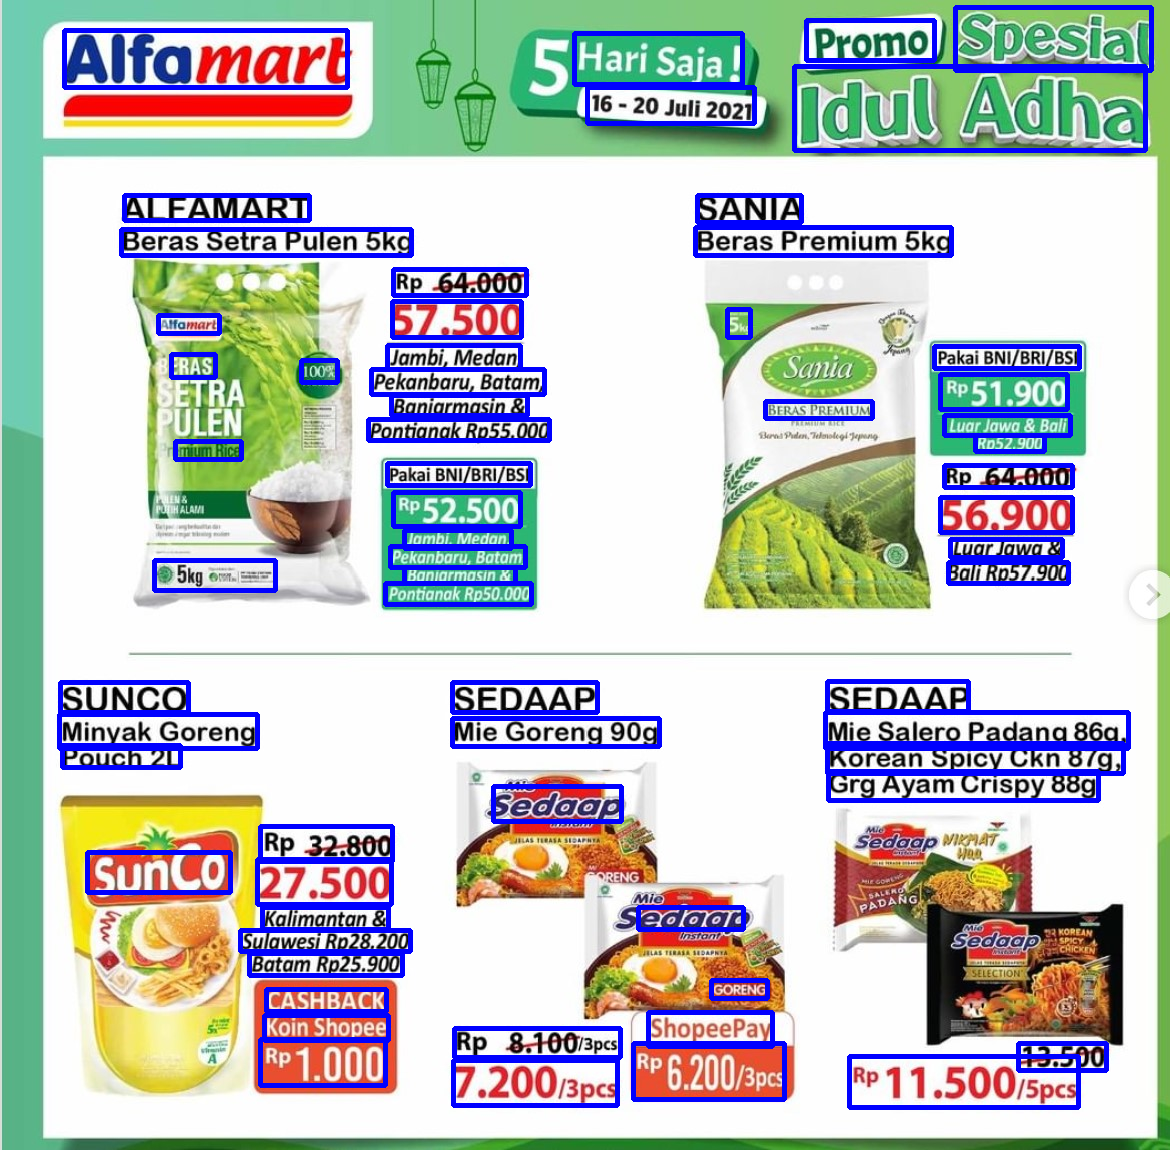

In [ ]:
# show results from OCR
original_boxes =  df[['pos1_x','pos1_y','pos3_x','pos3_y']].values.tolist()
original_img = cv2.imread('alpha_mart3.jpg')
image = draw_bounding_boxes(original_img,original_boxes)
cv2_imshow(image)

### Expand four edges of bounding boxes out   

In [ ]:
# use space between two letter as reference
# height to width ratio of alphabet is 5:3
x_diff = -df.loc[10,'pos1'][0] + df.loc[10,'pos2'][0]
y_diff = -df.loc[10,'pos1'][1] + df.loc[10,'pos3'][1]
num_letter = len(df.loc[10,'text'])
threshold = (x_diff - (y_diff/5*3)*num_letter)/(num_letter-1)
threshold = int(threshold)

In [ ]:
df.pos1_x = df.pos1_x-4*threshold
df.pos1_y = df.pos1_y-4*threshold
df.pos2_x = df.pos2_x+4*threshold
df.pos2_y = df.pos2_y-4*threshold
df.pos3_x = df.pos3_x+4*threshold
df.pos3_y = df.pos3_y+4*threshold
df.pos4_x = df.pos4_x-4*threshold
df.pos4_y = df.pos4_y+4*threshold
for i in range(1,5):
  col_name = 'pos' + str(i) + '_x'
  df[col_name] = df[col_name].apply(lambda x: 1 if x<0 else x)
  col_name = 'pos' + str(i) + '_y'
  df[col_name] = df[col_name].apply(lambda x: 1 if x<0 else x)

In [ ]:
boxes_redundant = df[['pos1_x','pos1_y','pos3_x','pos3_y']].values.tolist()

In [ ]:
combined_ind = NMS(np.array(boxes_redundant).astype(int), 0)
non_overlapping = pool(combined_ind)
boxes = []
for arr in non_overlapping:
  #print(arr)
  ind_arr = np.array(arr)
  #print(ind_arr)
  selected_area = np.array(boxes_redundant)[ind_arr]
  #print(selected_area)
  # find the largest area bounded by the group of indexes
  xx1 = min(selected_area[:,0])
  yy1 = min(selected_area[:,1])
  xx2 = max(selected_area[:,2])
  yy2 = max(selected_area[:,3])
  boxes.append(list([xx1,yy1,xx2,yy2]))

In [ ]:
image = draw_bounding_boxes(original_img,boxes_redundant)

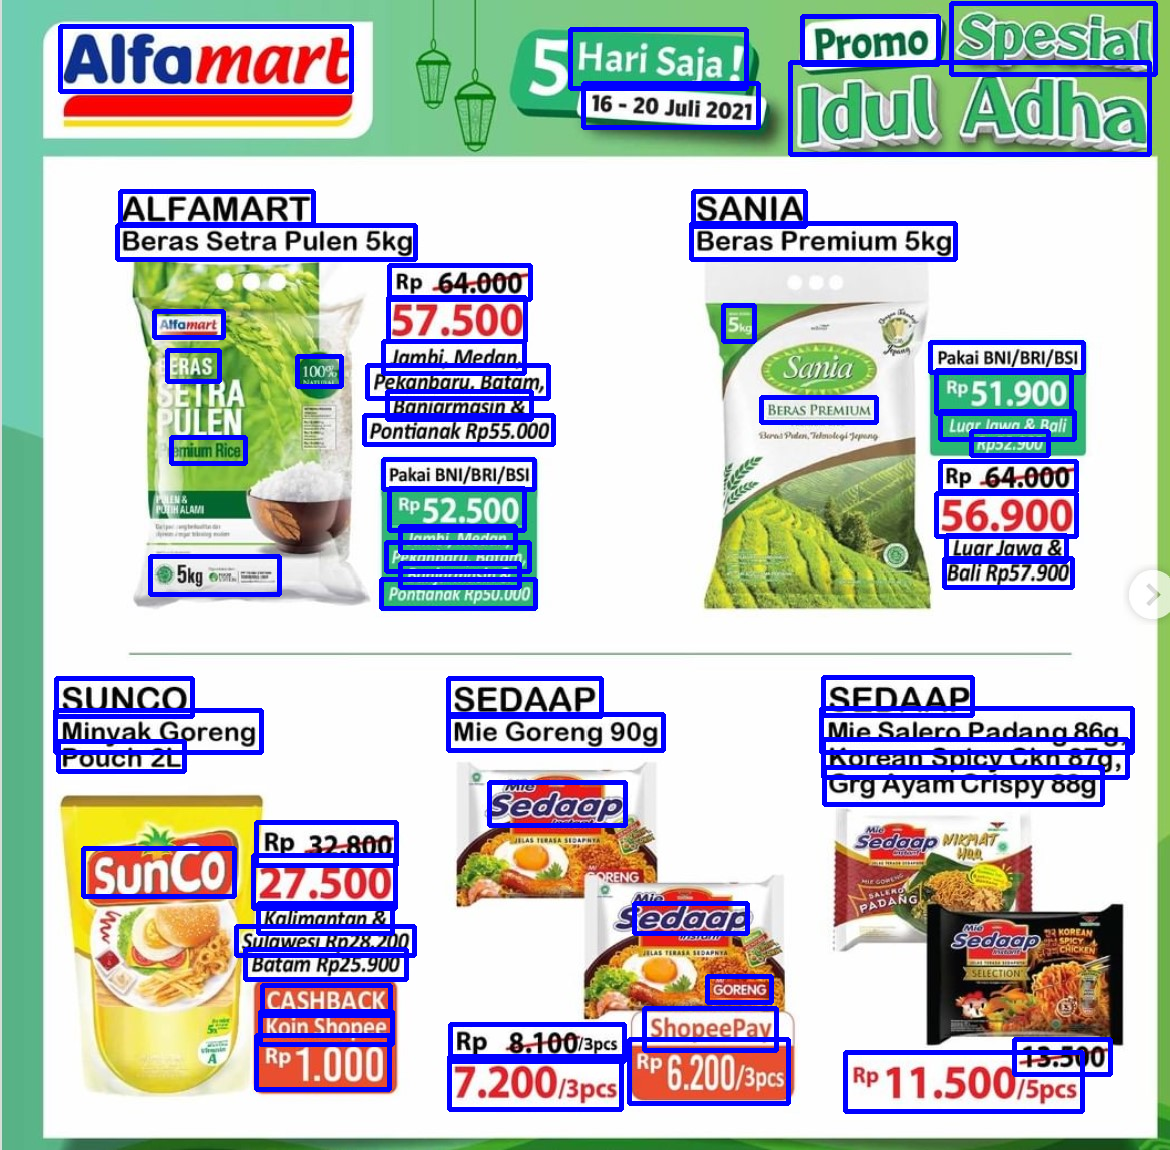

In [ ]:
cv2_imshow(image)

### Convert area of interest to black

In [ ]:
# color bounding boxes (after expansion) area to black
image = copy.deepcopy(original_img)
for box in boxes_redundant:
  image = cv2.rectangle(image,tuple(box[:2]), tuple(box[2:]), (0, 0, 0), -1)

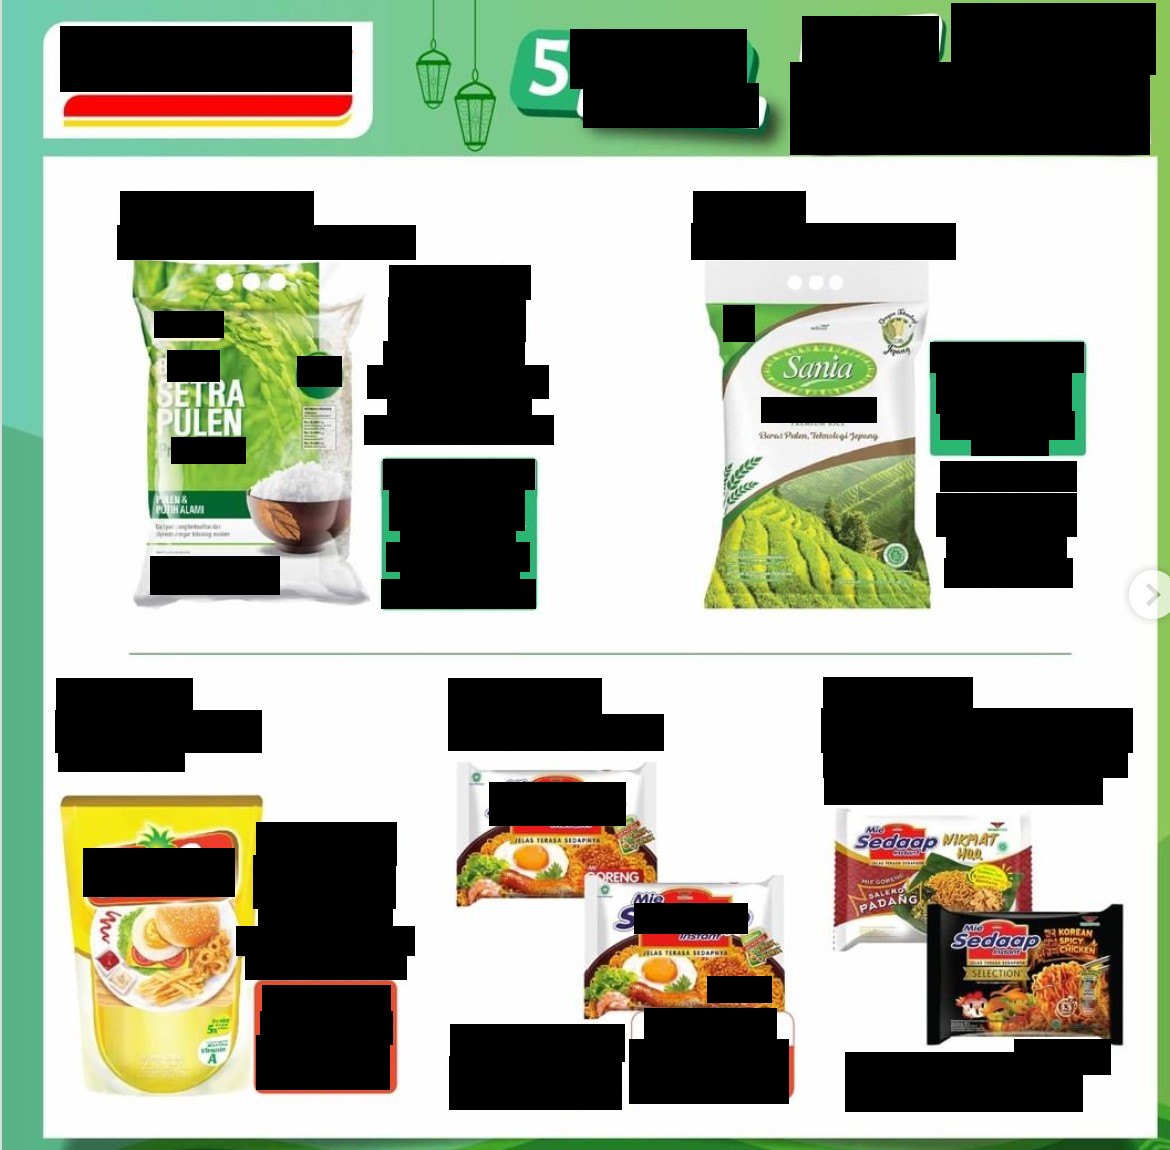

In [ ]:
cv2_imshow(image)

In [ ]:
# convert image to GRAY
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

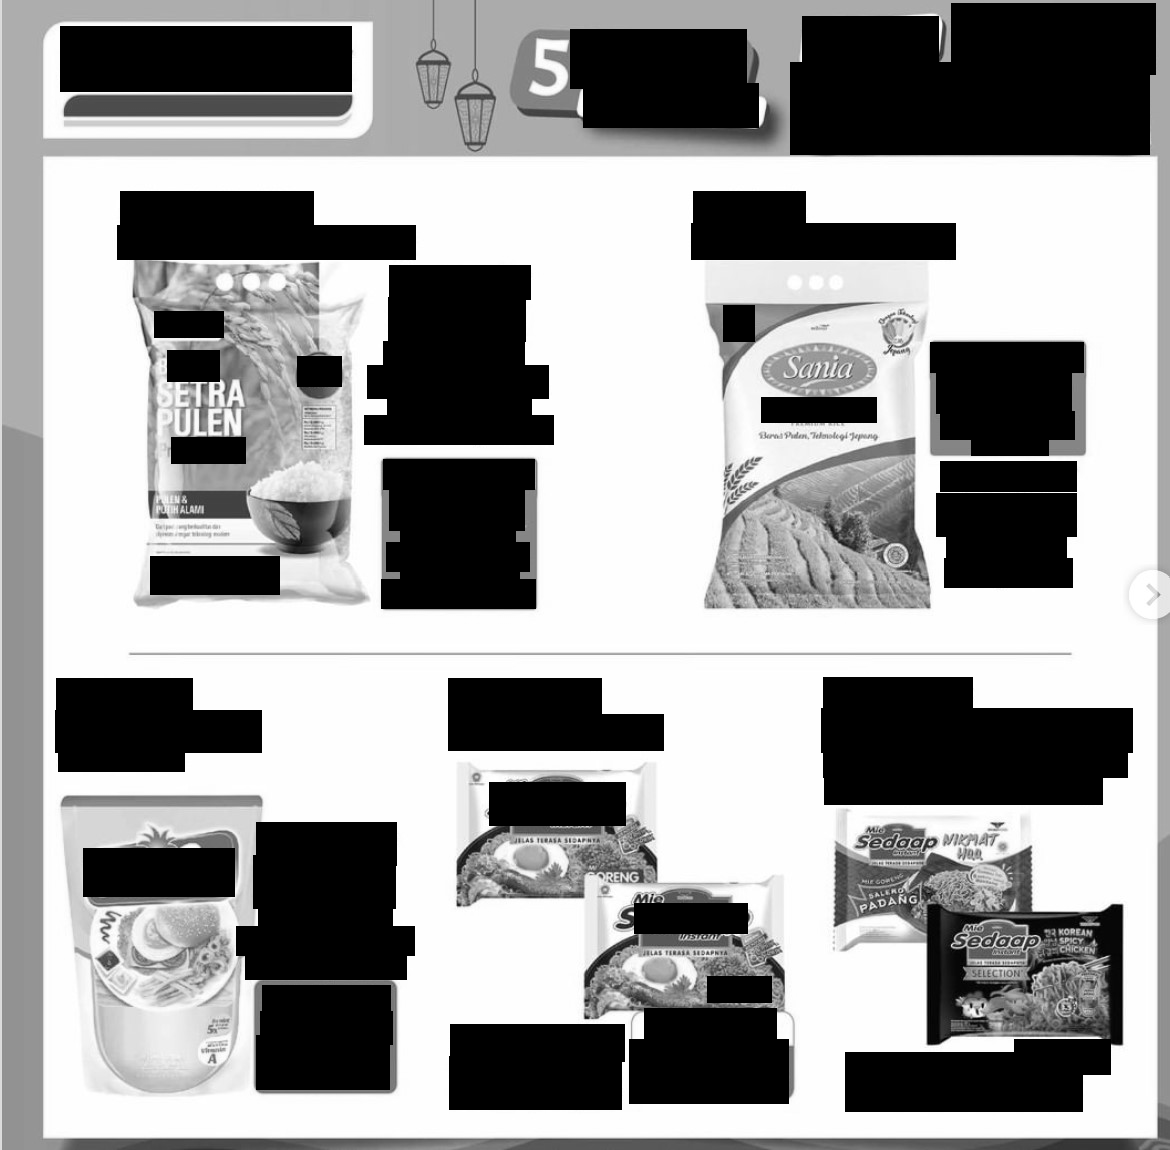

In [ ]:
cv2_imshow(image_gray)

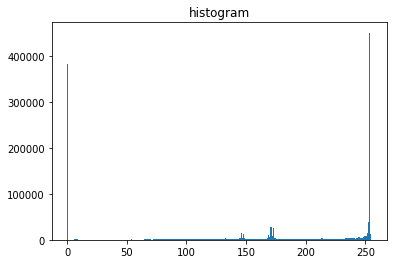

In [ ]:
'''
plt.subplot(1,2,1)
plt.imshow(image_gray,cmap='gray')
plt.title('image')
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
'''
plt.hist(image_gray.ravel(),256,[0,255])
plt.title('histogram')

plt.show()

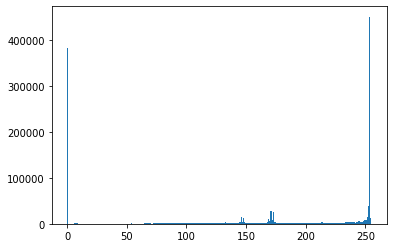

In [ ]:
y, x, _ = plt.hist(image_gray.ravel(),256,[0,255])

In [ ]:
threshold = 250

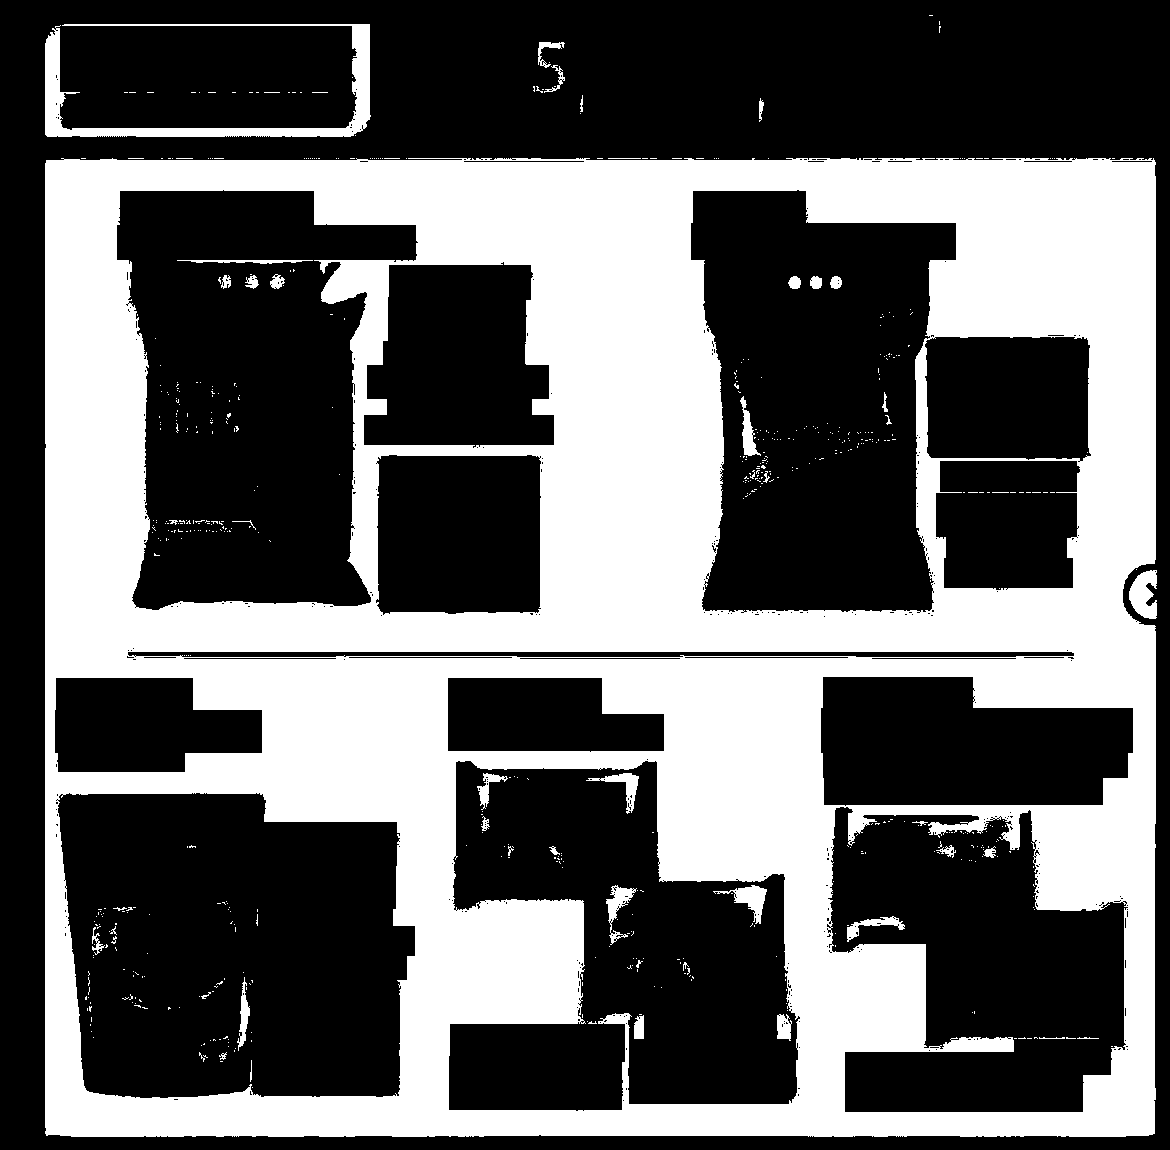

In [ ]:
# convert pixles larger than threshold (near white) to white(255) , otherwise set to 0
ret, thresh1 = cv2.threshold(image_gray, threshold, 255, cv2.THRESH_BINARY)
cv2_imshow( thresh1)

### Remove image boarder and other noises

In [ ]:
# detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
contours, hierarchy = cv2.findContours(image=thresh1, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

# draw contours on the original image
image_copy = original_img.copy()
cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)

array([[[220, 218, 218],
        [223, 229, 206],
        [176, 196, 124],
        ...,
        [ 89, 199, 140],
        [ 89, 199, 141],
        [ 89, 199, 141]],

       [[220, 218, 218],
        [223, 229, 206],
        [176, 196, 124],
        ...,
        [ 89, 199, 140],
        [ 89, 199, 141],
        [ 89, 199, 141]],

       [[220, 218, 218],
        [223, 229, 206],
        [176, 196, 124],
        ...,
        [ 89, 199, 140],
        [ 89, 199, 141],
        [ 89, 199, 141]],

       ...,

       [[215, 220, 219],
        [216, 230, 206],
        [140, 170,  99],
        ...,
        [ 58, 162,  74],
        [ 59, 165,  72],
        [ 57, 166,  68]],

       [[215, 220, 219],
        [216, 230, 206],
        [140, 170,  99],
        ...,
        [ 50, 150,  62],
        [ 51, 155,  62],
        [ 50, 157,  61]],

       [[215, 220, 219],
        [216, 230, 206],
        [140, 170,  99],
        ...,
        [ 32, 132,  44],
        [ 42, 143,  51],
        [ 42, 146,  51]]

In [ ]:
# largest contour area is corresponding to the background of frame of the image
max_area = 0
max_ind = 0
for i in range(len(contours)):
  if cv2.contourArea(contours[i])>max_area:
    max_area = cv2.contourArea(contours[i])
    max_ind = i

In [ ]:
fill_color = 255
mask_value = 255            # 1 channel white (can be any non-zero uint8 value)
# our stencil - some `mask_value` contours on black (zeros) background,
# the image has same height and width as `img`, but only 1 color channel
stencil  = np.zeros(image.shape[:-1]).astype(np.uint8)
cv2.fillPoly(stencil, [contours[max_ind]], mask_value)
sel         = stencil != mask_value # select everything that is not mask_value(not white->border)
image_remove_border = thresh1.copy()
image_remove_border[sel] = fill_color

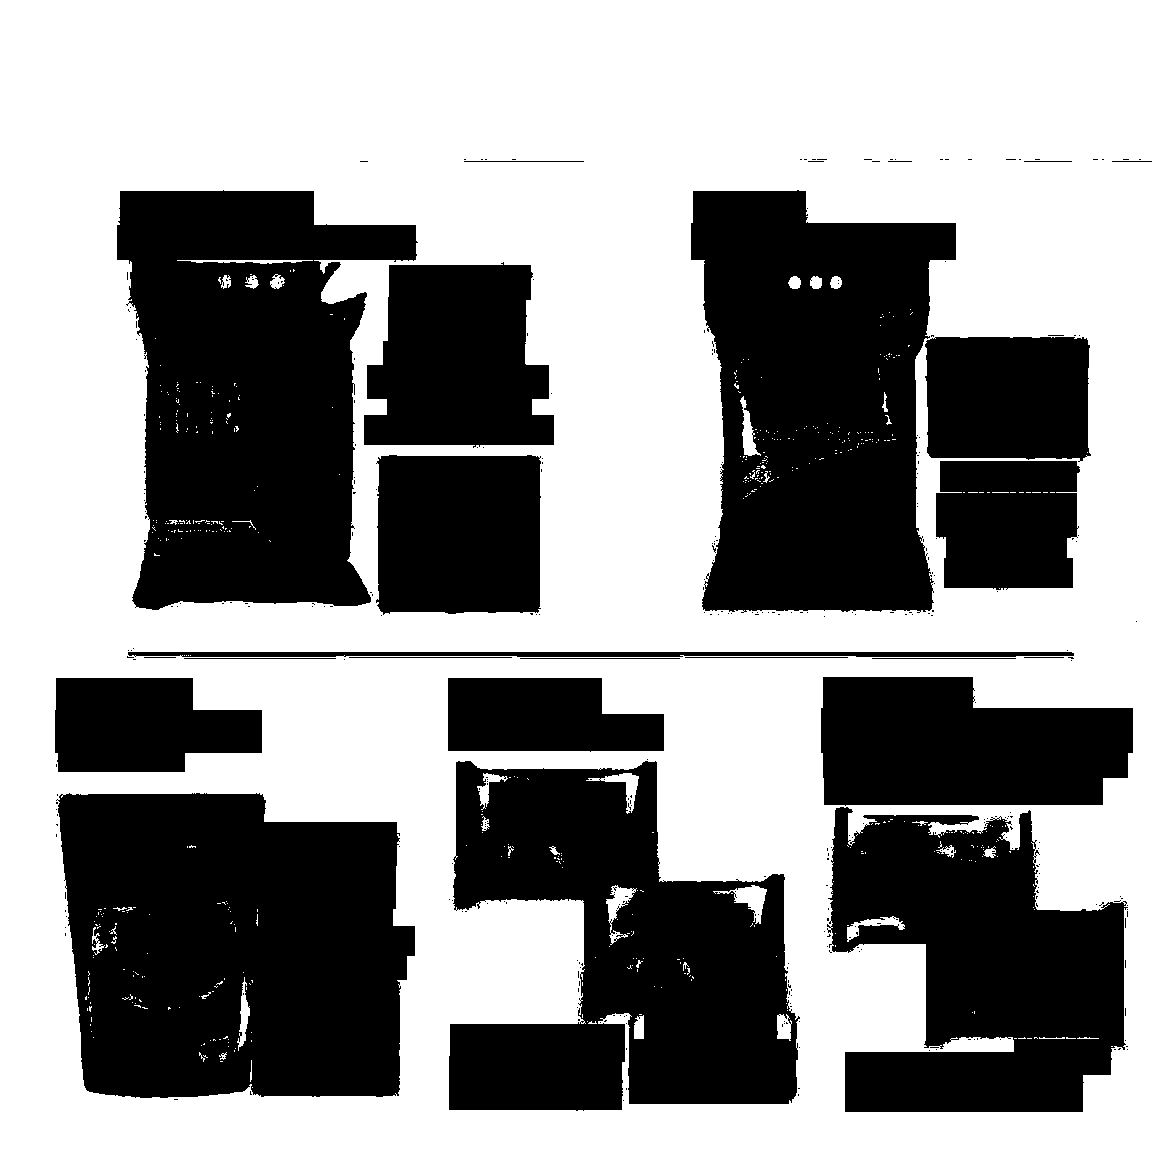

In [ ]:
cv2_imshow(image_remove_border)

In [ ]:
# remove objects (contoured area when their ratio between w and h is too extreme: noise)
# detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
contours, hierarchy = cv2.findContours(image=image_remove_border, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
# remove countours with extreme ratio between length and width
max_ratio = 0
min_ratio = 999999999
max_ind = 0
min_ind = 0
image_remove_ext = image_remove_border.copy()
for i in range(len(contours)):
  x,y,w,h = cv2.boundingRect(contours[i])
  r = w/h
  if r>20:
    fill_color = 255
    mask_value = 255            # 1 channel white (can be any non-zero uint8 value)
    # our stencil - some `mask_value` contours on black (zeros) background,
    # the image has same height and width as `img`, but only 1 color channel
    stencil  = np.zeros(image.shape[:-1]).astype(np.uint8)
    cv2.fillPoly(stencil, [contours[i]], mask_value)
    sel         = stencil ==255 # select everything that is not mask_value(not white->border)

    image_remove_ext[sel] = fill_color

  if r<1/20:
    mask_value = 255            # 1 channel white (can be any non-zero uint8 value)
    # our stencil - some `mask_value` contours on black (zeros) background,
    # the image has same height and width as `img`, but only 1 color channel
    stencil  = np.zeros(image.shape[:-1]).astype(np.uint8)
    cv2.fillPoly(stencil, [contours[i]], mask_value)
    sel         = stencil ==255 # select everything that is not mask_value(not white->border)

    image_remove_ext[sel] = fill_color


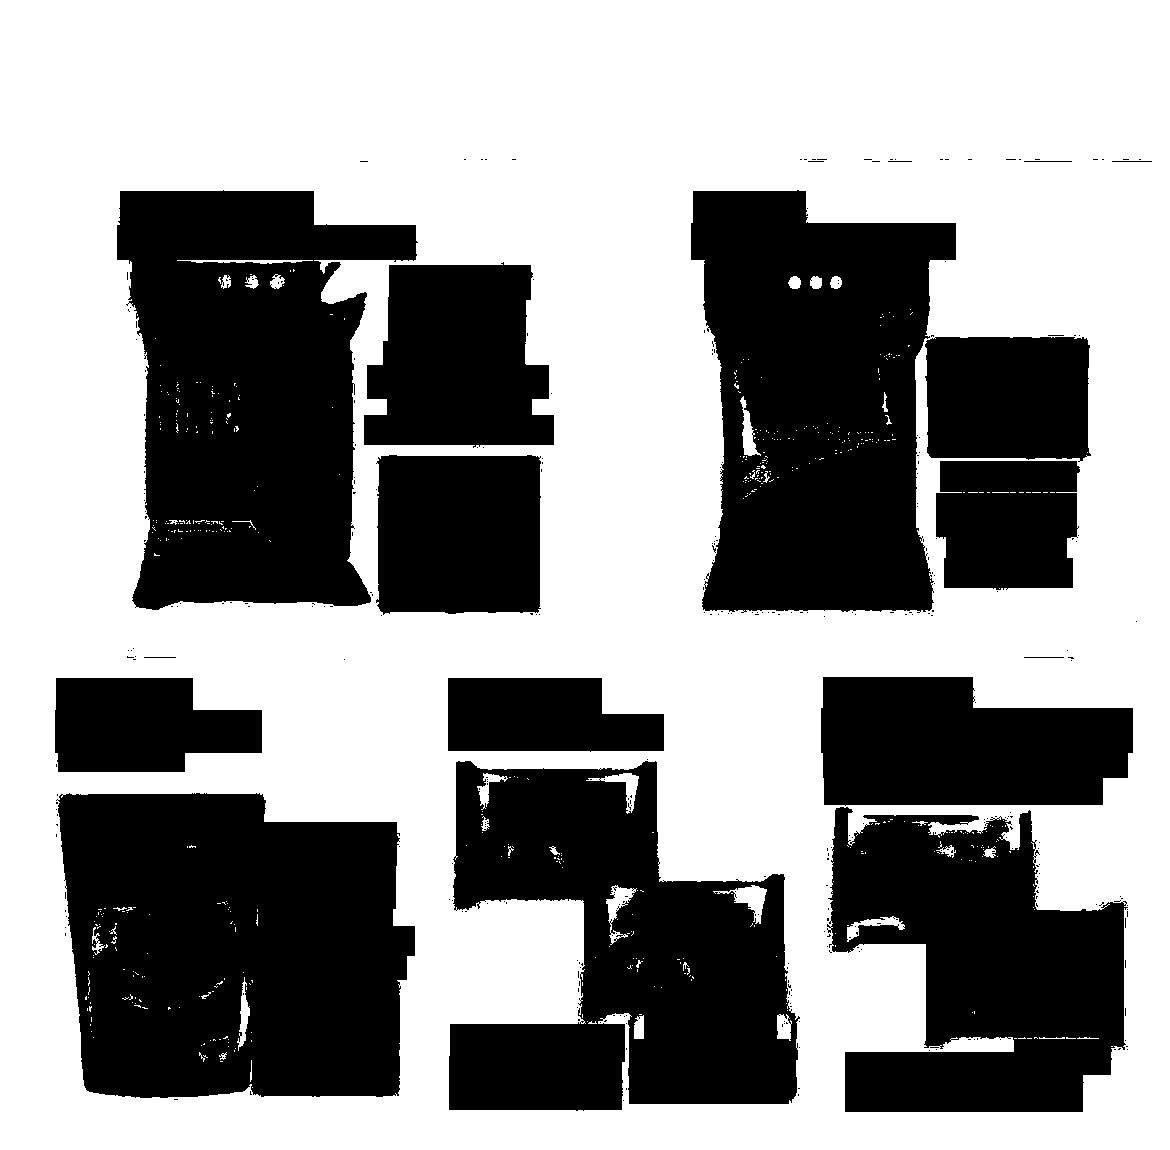

In [ ]:
cv2_imshow(image_remove_ext)

### Image segmentation (seperate info related to each individual product)

In [ ]:
kernel = np.ones((30,30), np.uint8)

# The first parameter is the original image,
# kernel is the matrix with which image is
# convolved and third parameter is the number
# of iterations, which will determine how much
# you want to erode/dilate a given image.
img_erosion = cv2.erode(image_remove_ext, kernel, iterations=1)
img_dilation = cv2.dilate(img_erosion, kernel, iterations=1)

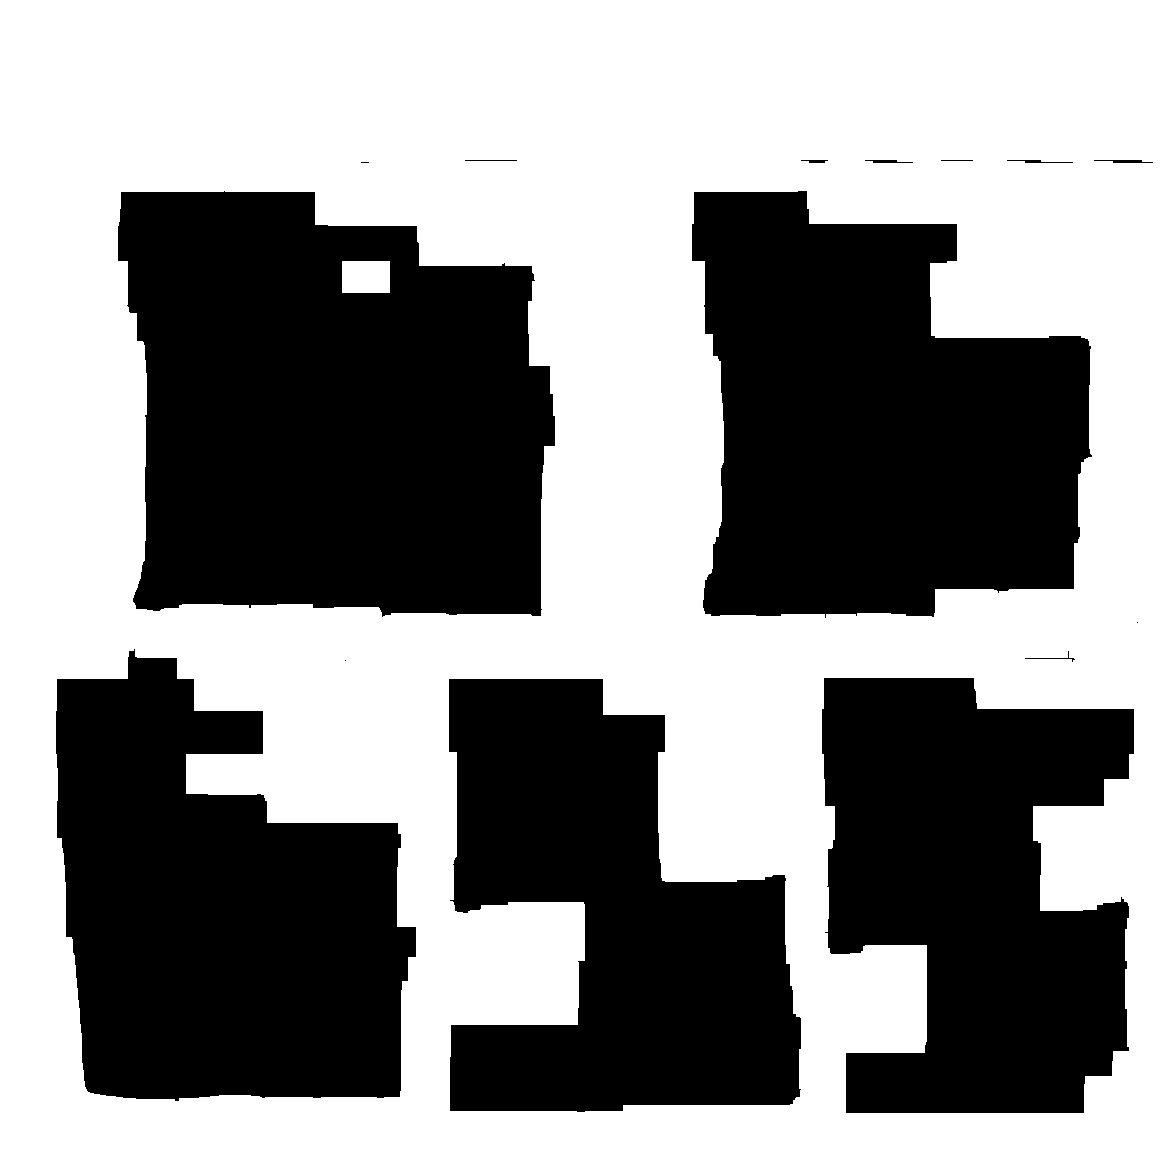

In [ ]:
cv2_imshow(img_dilation)

In [ ]:
contours, hierarchy = cv2.findContours(image=img_dilation, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

In [ ]:
len(contours)

17

In [ ]:

image_with_big_contour = original_img.copy()
cv2.drawContours(image=image_with_big_contour, contours=contours, contourIdx=-1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)

array([[[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [176, 196, 124],
        ...,
        [ 89, 199, 140],
        [  0, 255,   0],
        [  0, 255,   0]],

       ...,

       [[  0, 255,   0],
        [  0, 255,   0],
        [140, 170,  99],
        ...,
        [ 58, 162,  74],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

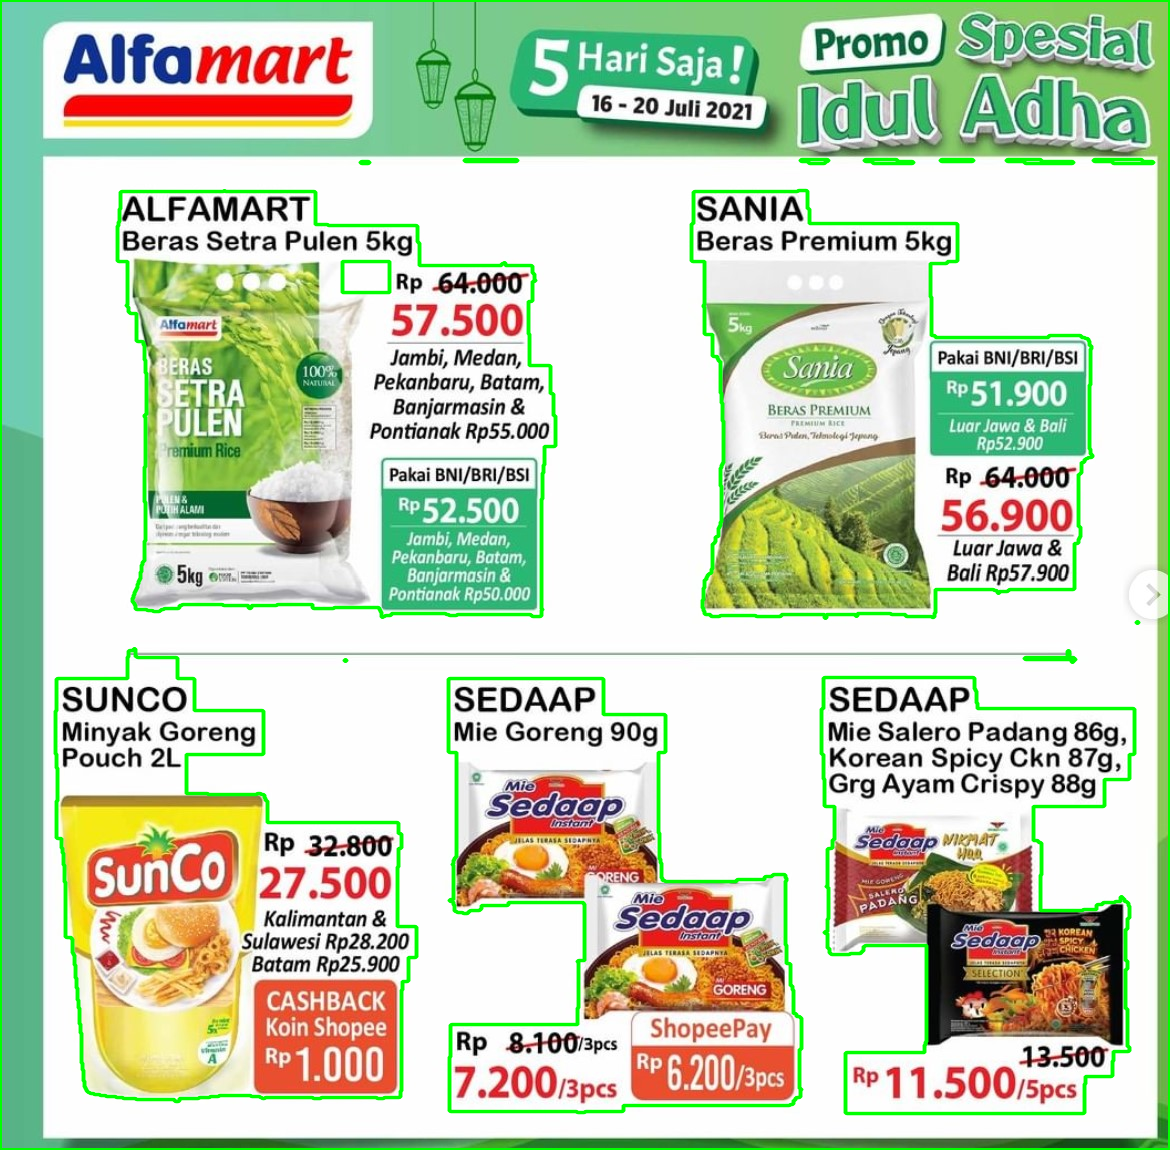

In [ ]:
cv2_imshow(image_with_big_contour)

In [ ]:
# remove contours if they are too small or too big compared to image size
height, width, channels = image_with_big_contour.shape
max_area = 0
max_ind = 0
contour_to_del = []
for i in range(len(contours)):
  if cv2.contourArea(contours[i])>(height * width*0.99):
    contour_to_del.append(i)
  if cv2.contourArea(contours[i])<(height * width/500):
    contour_to_del.append(i)

In [ ]:
for index in sorted(contour_to_del, reverse=True):
    del contours[index]

In [ ]:
len(contours)

5

In [ ]:
image_with_big_contour = original_img.copy()
cv2.drawContours(image=image_with_big_contour, contours=contours, contourIdx=-1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)

array([[[220, 218, 218],
        [223, 229, 206],
        [176, 196, 124],
        ...,
        [ 89, 199, 140],
        [ 89, 199, 141],
        [ 89, 199, 141]],

       [[220, 218, 218],
        [223, 229, 206],
        [176, 196, 124],
        ...,
        [ 89, 199, 140],
        [ 89, 199, 141],
        [ 89, 199, 141]],

       [[220, 218, 218],
        [223, 229, 206],
        [176, 196, 124],
        ...,
        [ 89, 199, 140],
        [ 89, 199, 141],
        [ 89, 199, 141]],

       ...,

       [[215, 220, 219],
        [216, 230, 206],
        [140, 170,  99],
        ...,
        [ 58, 162,  74],
        [ 59, 165,  72],
        [ 57, 166,  68]],

       [[215, 220, 219],
        [216, 230, 206],
        [140, 170,  99],
        ...,
        [ 50, 150,  62],
        [ 51, 155,  62],
        [ 50, 157,  61]],

       [[215, 220, 219],
        [216, 230, 206],
        [140, 170,  99],
        ...,
        [ 32, 132,  44],
        [ 42, 143,  51],
        [ 42, 146,  51]]

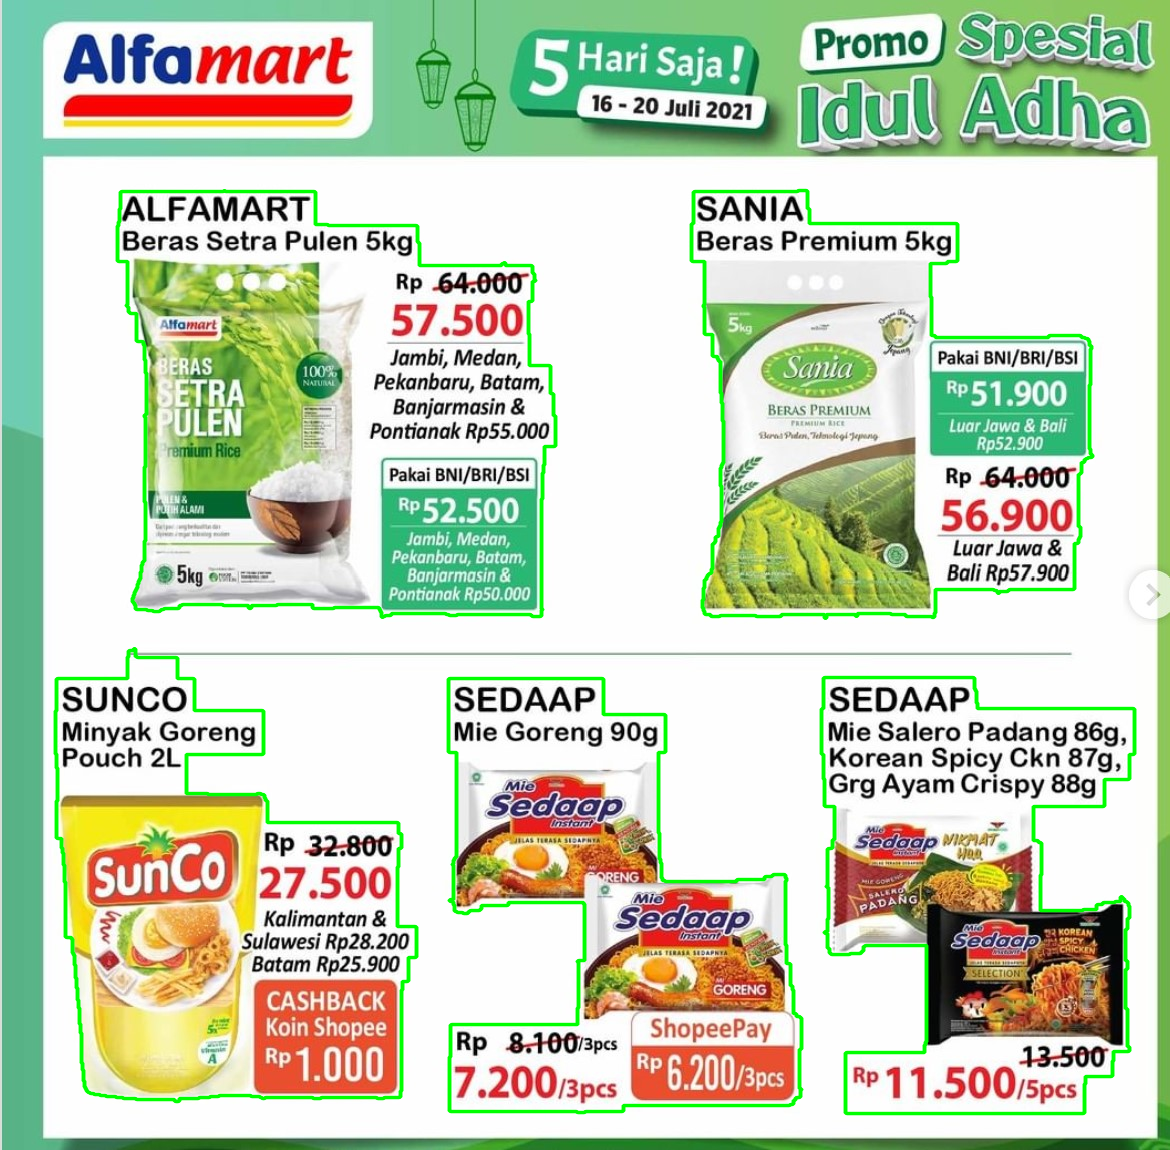

In [ ]:
cv2_imshow(image_with_big_contour)

### Text extration for individual products

In [ ]:
# loop to find min and max x, y corresponding each of the product
x1 = []
y1 = []
x2 = []
y2 = []
# Going through every contours found in the image.
for cnt in contours :
    x1.append(cnt[:,0,0].min())
    x2.append(cnt[:,0,0].max())
    y1.append(cnt[:,0,1].min())
    y2.append(cnt[:,0,1].max())

In [ ]:
# original x and y of point 1 and 3 (before expansion)
for i in [1,3]:
  pos_name = 'pos'+ str(i)
  pos_name_new1 = pos_name+'_x_org'
  pos_name_new2 = pos_name+'_y_org'
  split_df = pd.DataFrame(df[pos_name].tolist(), columns=[pos_name_new1, pos_name_new2])
  df = pd.concat([df,split_df],axis = 1)

In [ ]:
x1,x2,y1,y2

([448, 821, 55, 691, 117],
 [801, 1134, 416, 1092, 555],
 [678, 677, 648, 190, 190],
 [1112, 1113, 1101, 618, 617])

In [ ]:
df['grp'] = -1

In [ ]:
# attach level 1 grouping to the text extracted, -1 refers to background information
for index, row in df.iterrows():
  #loop through bounding areas
  for i in range(len(x1)):
    if row['pos1_x_org'] >= x1[i] and  row['pos3_x_org'] <= x2[i] and row['pos1_y_org'] >= y1[i] and  row['pos3_y_org'] <= y2[i]:
      df.at[index,'grp'] = i
      #print(row['pos1_x_org'])
      #print(x1[i])
    i= i+1


In [ ]:
# attach level 2 grouping to the text. if two texts belong to the same bounding boxes (after expansion), they will have the same level 2 grouping
df['lvl2_grp'] = -1
for index, row in df.iterrows():
  #loop through bounding areas
  for i in range(len(boxes)):
    if row['pos1_x_org'] >= boxes[i][0] and  row['pos3_x_org'] <= boxes[i][2] and row['pos1_y_org'] >= boxes[i][1] and  row['pos3_y_org'] <= boxes[i][3]:
      df.at[index,'lvl2_grp'] = i

    i= i+1


In [ ]:
# concatenate texts belong to the same lvl2_grp
df['final_text'] = df[['text','grp','lvl2_grp']].groupby(['grp','lvl2_grp'])['text'].transform(lambda x: ','.join(x))

In [ ]:
result_df = df[['final_text','grp','lvl2_grp']].drop_duplicates().sort_values(['grp','lvl2_grp'])

## Text cleaning

In [ ]:
#result_df.final_text = result_df.final_text.apply(lower_casing_text)
result_df.final_text = result_df.final_text.apply(removing_special_characters)
result_df.final_text = result_df.final_text.apply(accented_characters_removal)
result_df.final_text = result_df.final_text.apply(remove_whitespace)
result_df.final_text = result_df.final_text.apply(remove_other_char)


In [ ]:
result_df = result_df[result_df.final_text!='']

In [ ]:
result_df['lower'] = result_df.final_text.str.lower()

In [ ]:
# remove content if it is fully contained by another string in the same grp
result_df['comb'] = result_df[['lower','grp']].groupby(['grp'])['lower'].transform(lambda x: '+'.join(x))
def find_occ_of_word(row):
  return row['comb'].count(row['lower'])
result_df['count_occ'] = result_df.apply(find_occ_of_word,axis = 1)
result_df = result_df[result_df['count_occ']==1]
result_df = result_df.drop_duplicates(['final_text','grp'])
result_df = result_df.reset_index(drop = True)

In [ ]:
result_df.to_csv('result.csv')